# Question 1

This script compares the approaches of separately filtering then maximally downsampling versus applying a polyphase downsampling filter.

In [54]:
from pathlib import Path

import numpy as np
import scipy.fft as fft
import scipy.signal as signal

import matplotlib.pyplot as plt
import seaborn as sns

from a3_config import A3_ROOT, SAVEFIG_CONFIG

In [55]:
# Define design specifications

FS     = 40     # sampling frequency, kHz
F_PASS = 0.2    # cutoff frequency, kHz
F_STOP = 0.3    # stop band frequency, kHz
A_PASS = 3      # pass band attenuation, dB
A_STOP = 100    # stop band attenuation, dB

### Construct Signal

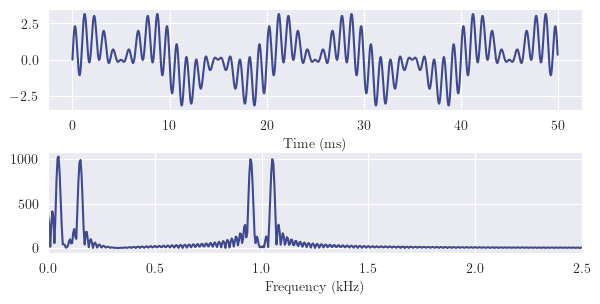

In [56]:
# Create signal with tones at: 50, 150, 950, 1050 Hz sampled at 40 kHz
t = np.arange(0, 50, 1 / FS)
x = np.sin(2 * np.pi * 0.05 * t) + \
    np.sin(2 * np.pi * 0.15 * t) + \
    np.sin(2 * np.pi * 0.95 * t) + \
    np.sin(2 * np.pi * 1.05 * t)

f = fft.fftfreq(8192, 1 / FS)[:4096]
H = fft.fft(x, 8192)[:4096]

fig, axs = plt.subplots(2, figsize=(6, 3))
fig.tight_layout()

sns.lineplot(x=t, y=x, ax=axs[0])
sns.lineplot(x=f, y=np.abs(h), ax=axs[1])

axs[0].set_xlabel("Time (ms)")
axs[1].set_xlabel("Frequency (kHz)")
axs[1].set_xlim([0, 2.5])

# fname = Path(A3_ROOT, "output", "q1_original_signal.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()

### Apply Kaiser LPF

In [57]:
ripple_p = 1 - np.power(10, -A_PASS / 20)
ripple_s = np.power(10, -A_STOP / 20)
print("Maximum pass band ripple:", ripple_p)
print("Maximum stop band ripple:", ripple_s)

A = -20 * np.log10(min(ripple_p, ripple_s))
print("Required attenuation:", A, "dB")

Maximum pass band ripple: 0.2920542156158621
Maximum stop band ripple: 1e-05
Required attenuation: 100.0 dB


In [71]:
# Kaiser window filter length estimate
N = int(np.ceil((A - 7.95)/(14.36 * ((F_STOP - F_PASS) / FS))))
N = N + 1 if (N % 2) else N
print("Filter length estimate:", N)

beta = 0.1102 * (A - 8.7)
print("Kaiser window beta:", beta)

Filter length estimate: 2566
Kaiser window beta: 10.06126


Create the frequency domain vector, $V$, which represents the ideal frequency response.

Bins in passband: 13


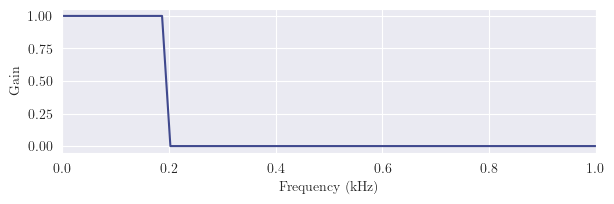

In [72]:
# Calculate pass band width, L
L = int(np.round(N * (F_PASS) / FS))
print("Bins in passband:", L)

# Construct V, with 1's in the pass band and 0's in the stop band
V = np.zeros(N//2)
V[:L] = np.ones(L)
V = np.concatenate([V, np.flip(V)])

# Construct a frequency axis for plotting
f = np.linspace(0, FS, N)

# Plot ideal frequency response, represented by vector V
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

sns.lineplot(x=f[:N//2], y=V[:N//2], ax=ax)
ax.set_xlim([0, 1])
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Gain")

# fname = Path(A3_ROOT, "output", "q4_ideal_freqz.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()

In [73]:
# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def plot_freqz(w, h, fname=None):
    """Plot frequency response and overlay filter requirements."""
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout()
    sns.lineplot(x=w, y=dB(np.abs(h)), ax=ax)
    # Plot pass band requirement
    ax.axhline(-3, c="g", lw=0.5, label="Pass band requirement")
    ax.axvline(0.3, c="g", lw=0.5)
    # Plot pass band requirement
    ax.axhline(-100, c="r", lw=0.5, label="Stop band requirement")
    ax.axvline(0.5, c="r", lw=0.5)
    # Axis labels
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Gain (dB)")
    ax.legend(framealpha=1)
    # Save or just show
    if fname:
        fig.savefig(Path(A3_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

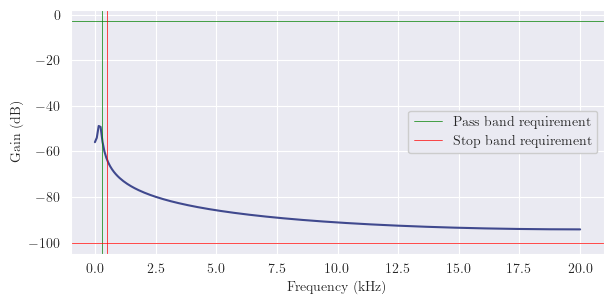

In [76]:
# Impulse (time) response of ideal filter
v = fft.fftshift(fft.ifft(V))

# Construct and apply the Kaiser window
v_kaiser = v * signal.windows.kaiser(N, beta)
V_kaiser = fft.fft(v_kaiser, 512)[:256]

# Construct frequency axis for plotting
f = np.linspace(0, FS / 2, 256)

plot_freqz(f, V_kaiser)

In [86]:
# Apply filter to signal
x_filt = signal.convolve(v_kaiser, x)

(5132, 4565, 2000, 2566)